In [1]:
import numpy as np # linear algebra
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

In [2]:
df_master = pd.read_csv('historical_data.csv')

In [3]:
df = df_master.copy()

In [4]:
#MARK THIS AS TARGET VARIABLE
df['delivery_time'] = (pd.to_datetime(df['actual_delivery_time']) - pd.to_datetime(df['created_at'])).dt.total_seconds()
df['delivery_time'] = df['delivery_time'] - df['estimated_order_place_duration'] #<-- Customer driven so will factor this out

#CREATE SOME OTHER VARIABLES FOR ANALYSIS SUCH AS DAY, MONTH, HOUR
df['day_of_week_name'] = pd.to_datetime(df['created_at']).dt.day_name()
df['day_of_week_num'] = pd.to_datetime(df['created_at']).dt.dayofweek
df['month'] = pd.to_datetime(df['created_at']).dt.month
df['time'] = pd.to_datetime(df['created_at']).dt.hour

# Rename other as misc in store_primary_category
df['store_primary_category'] = df['store_primary_category'].replace(['other'], 'misc')

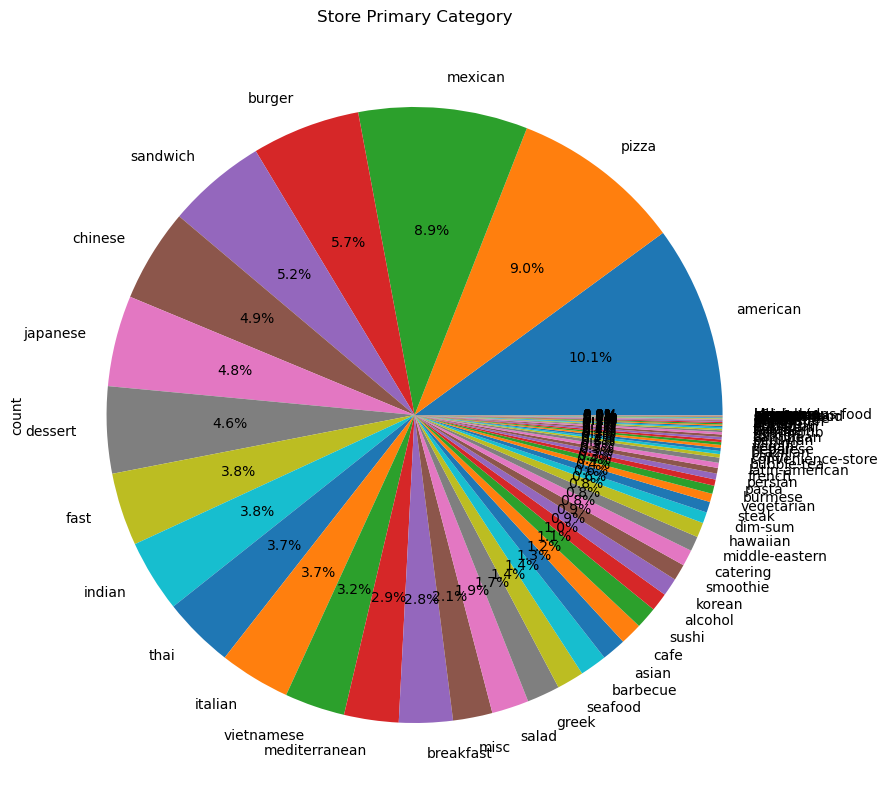

In [5]:
# Pie Chart on the store_primary_category

df['store_primary_category'].value_counts().plot.pie(autopct='%1.1f%%',figsize=(10,10))
plt.title('Store Primary Category')
plt.show()

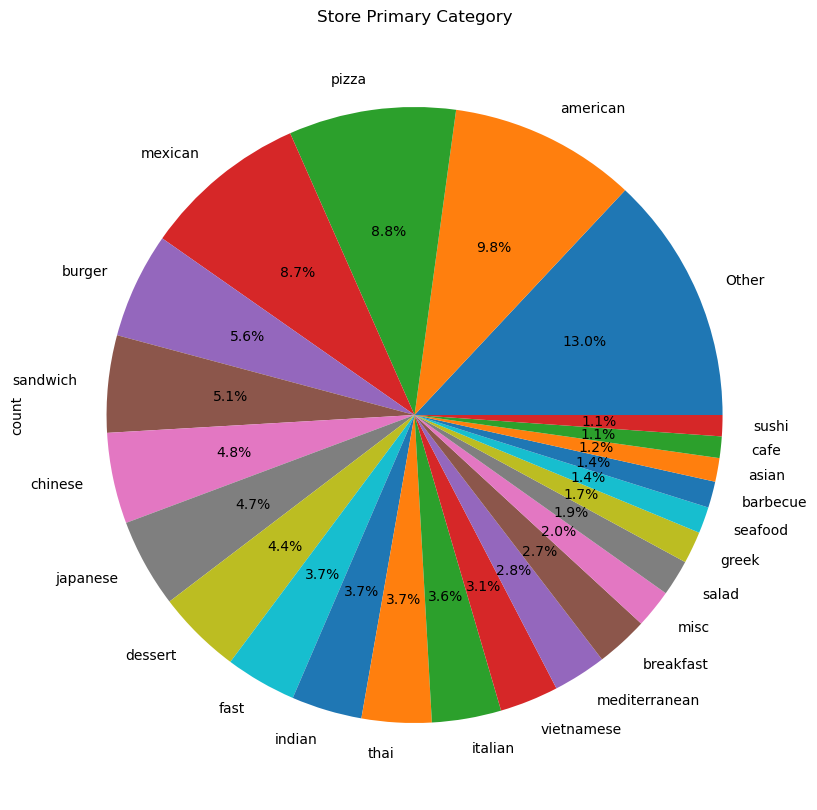

In [6]:
df_temp = df.copy()

# Calculate category frequencies
category_frequencies = df_temp['store_primary_category'].value_counts(normalize=True)

# Replace less frequent categories with 'Other' and handle NaN
df_temp['store_primary_category'] = df_temp['store_primary_category'].apply(
    lambda x: x if pd.notna(x) and category_frequencies.get(x, 0) > 0.01 else 'Other'
)

# Plot the pie chart
df_temp['store_primary_category'].value_counts().plot.pie(
    autopct='%1.1f%%', figsize=(10, 10)
)
plt.title('Store Primary Category')
plt.savefig('store_primary_category.png')

In [7]:
#GOING TO CREATE A VALUE THAT SHOWS % of AVAILABLE DASHERS, IN SOME CASES BUSY > IS GREATER THAN TOTAL AVAILABLE 
#SO I AM ASSUMING NO OVERLAP IN DRIVERS HERE. ALSO IN SOME CASES,  VALUE IS NEGATIVE AND I ASSUME THAT IS A DATA ERROR 
df['total_busy_dashers'] = abs(df['total_busy_dashers'])
df['total_onshift_dashers'] = abs(df['total_onshift_dashers'])

#CREAT TOTAL BUSY DASHERS / TOTAL DASHERS
df['%_dashers_avail'] = df['total_busy_dashers']/(df['total_onshift_dashers'] + 
                                                                      df['total_busy_dashers'])

In [8]:
len_before_outliers = len(df)

def find_outliers(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    df = df[(df[variable] > lower_boundary) &  (df[variable] < upper_boundary)]
    
    return df

#THERE ARE SOME VERY HIGH AND 0 SUBTOTALS, going to clean that up 
df2 = find_outliers(df, 'subtotal', 1.5).sort_values(by = ['subtotal'])
df2 = find_outliers(df2, 'delivery_time', 1.5).sort_values(by = ['delivery_time'])
df2 = find_outliers(df2, 'max_item_price', 1.5).sort_values(by = ['delivery_time'])

print(f"Length Before Outliers: {len_before_outliers}")
print(f"Length after Outliers Dropped: {len(df2)}")

Length Before Outliers: 197428
Length after Outliers Dropped: 175587


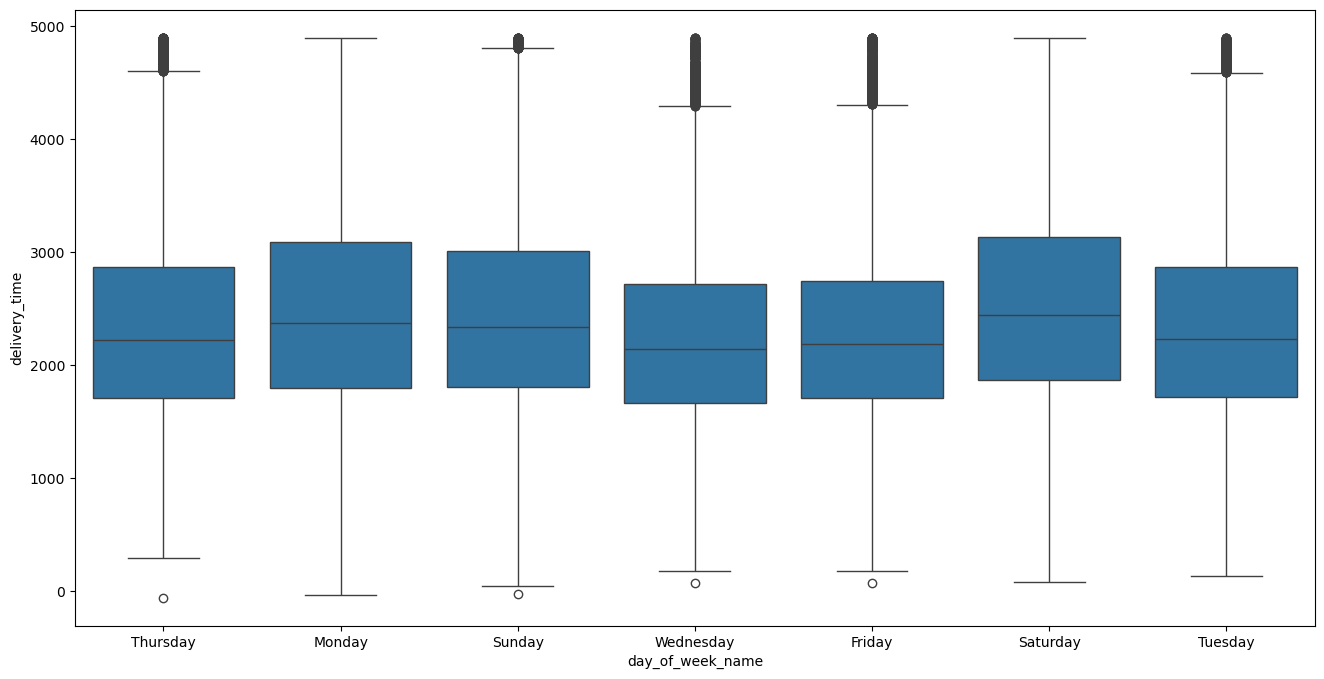

In [9]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='day_of_week_name', y="delivery_time", data=df2)

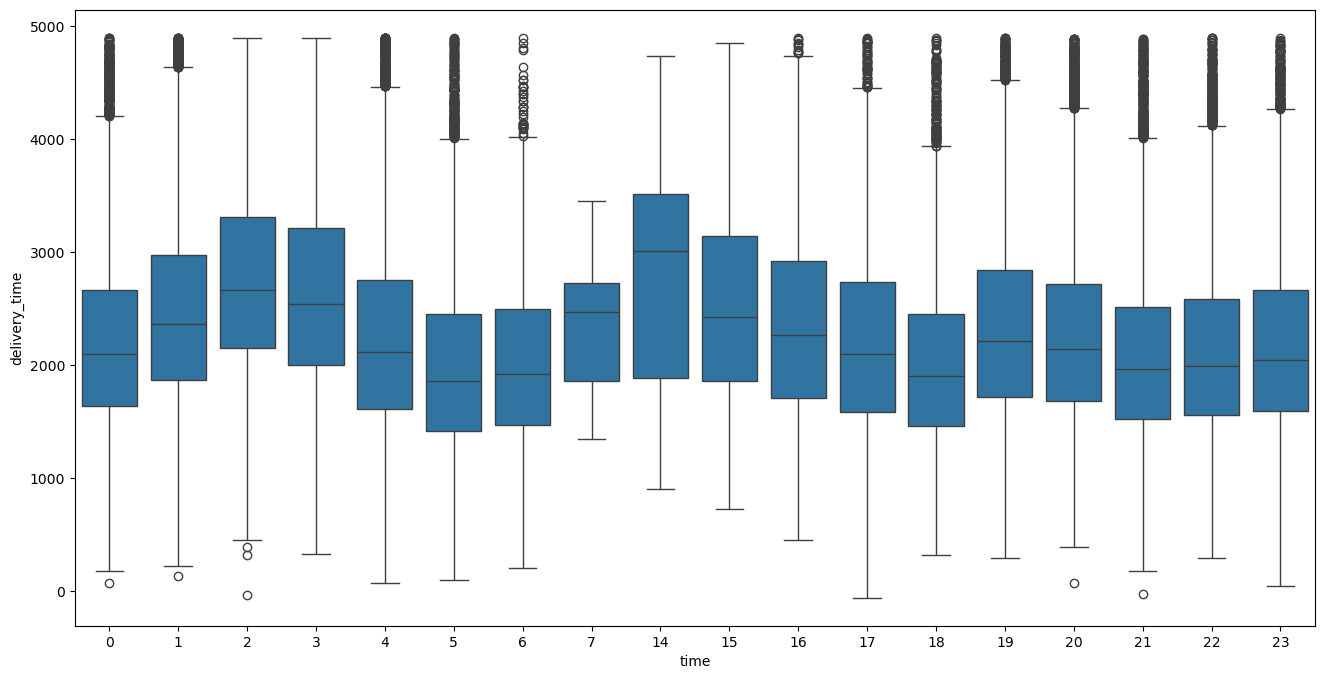

In [10]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='time', y="delivery_time", data=df2)

#HIGHER MEDIAN DELIVERY TIMES at 2am and 2pm. Oddly no data for 8am - 1pm. 7am, 2pm and 3pm dont have 
#outliers so it may be easier to predict those

# Variable Transformation

In [11]:
df_transform = df2.copy()

In [12]:
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)

le = LabelEncoder()

for cat_var in ['store_primary_category']:
    df_transform[cat_var] = le.fit_transform(df_transform[cat_var])

In [13]:
#GOING TO DROP A FEW VARIABLES
df_transform = df_transform.drop(columns = ['created_at',  #<--- Referenced in dependent
                             'actual_delivery_time',   #<--- Referenced in dependent
                             'day_of_week_name'  #<-- Dummy created
                            ])

In [14]:
#DROP NULLS
df_transform = df_transform.dropna(how='any',axis=0) 

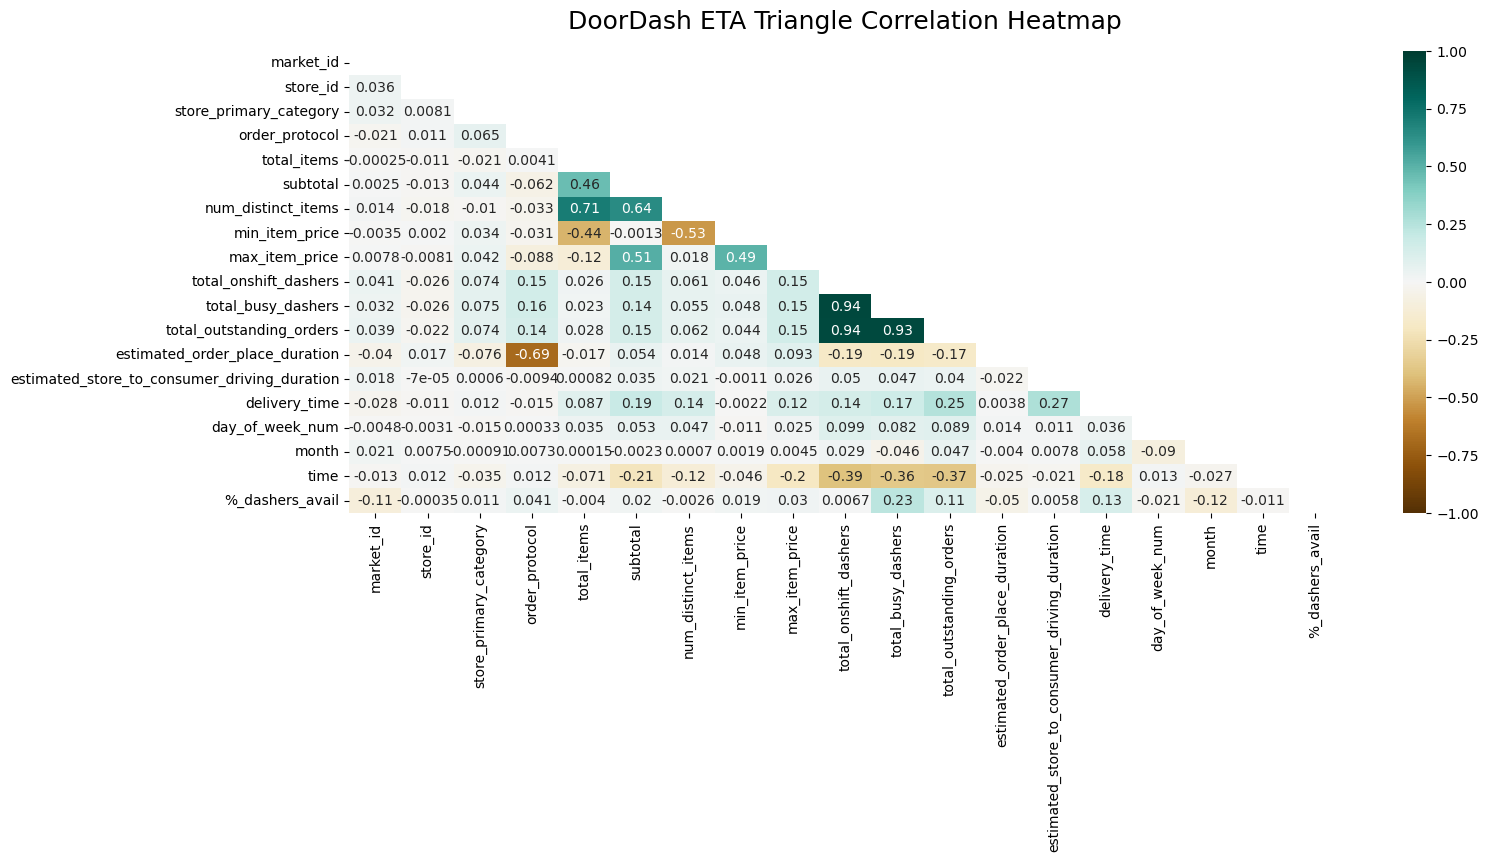

In [15]:
corr_matrix = df_transform.corr(method='pearson')

#correlation map
f,ax = plt.subplots(figsize=(16, 6))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('DoorDash ETA Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show() 

In [16]:
df_transform.columns

Index(['market_id', 'store_id', 'store_primary_category', 'order_protocol',
       'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_time',
       'day_of_week_num', 'month', 'time', '%_dashers_avail'],
      dtype='object')

In [17]:
#SOME COLUMNS ARE HIGHLY CORRELATED, GOING TO DROP A FEW:
df_transform = df_transform.drop(columns = ['min_item_price','num_distinct_items','order_protocol',
                                                               'total_onshift_dashers','total_busy_dashers','month'])

In [18]:
vif_data = pd.DataFrame() 
dependendent_df = df_transform.drop(columns = ['delivery_time'])

vif_data["feature"] = dependendent_df.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(dependendent_df.values, i) 
                          for i in range(len(dependendent_df.columns))] 
  
print(vif_data)

                                         feature        VIF
0                                      market_id   5.019220
1                                       store_id   3.872159
2                         store_primary_category   3.850793
3                                    total_items   3.997218
4                                       subtotal   9.645134
5                                 max_item_price  13.909812
6                       total_outstanding_orders   2.795859
7                 estimated_order_place_duration  11.174969
8   estimated_store_to_consumer_driving_duration   6.759200
9                                day_of_week_num   3.506160
10                                          time   2.339092
11                               %_dashers_avail  22.137066


In [59]:
# Removing outliers with GMM
temp_df = df_transform.copy()

from sklearn.mixture import GaussianMixture
import numpy as np

# Assuming 'Delivery Time' is the column of interest
data = temp_df['delivery_time'].values.reshape(-1, 1)

# Fit GMM
gmm = GaussianMixture(n_components=1, random_state=0)  # Use 1 component for univariate data
gmm.fit(data)

# Compute probabilities
probabilities = gmm.score_samples(data)
threshold = np.percentile(probabilities, 10)  # Define threshold for outliers (e.g., 2nd percentile)

# Identify inliers
inliers = probabilities > threshold

# Filter out outliers
df_gmm = temp_df[inliers]

print("Number of outliers removed:", len(temp_df) - len(df_gmm))

# Removing outliers with K Means
from sklearn.cluster import KMeans

temp_df = df_transform.copy()

# Assuming 'Delivery Time' is the column of interest
data = temp_df['delivery_time'].values.reshape(-1, 1)

# Fit KMeans
kmeans = KMeans(n_clusters=1, random_state=0)  # Use 2 clusters for univariate data
kmeans.fit(data)

# Compute distances
distances = kmeans.transform(data)

# min_distances = distances.min(axis=1)

threshold = np.percentile(distances, 90)  # Define threshold for outliers (e.g., 95th percentile)

# Identify inliers
inliers = distances < threshold

# Filter out outliers
df_kmeans = temp_df[inliers]

# print(len(df_kmeans))

print("Number of outliers removed:", len(temp_df) - len(df_kmeans))


Number of outliers removed: 15630
Number of outliers removed: 15630


In [60]:
# Number of outliers removed

print(f"Length Before Outliers: {len(df_master)}")
print(f"Length after Outliers Dropped KMeans: {len(df_kmeans)}")
print(f"Length after Outliers Dropped GMM: {len(df_gmm)}")

Length Before Outliers: 197428
Length after Outliers Dropped KMeans: 140600
Length after Outliers Dropped GMM: 140600


In [61]:
# Save the cleaned data
df_kmeans.to_csv('cleaned_kmeans.csv', index=False)
df_gmm.to_csv('cleaned_gmm.csv', index=False)

# Regression Testing

In [62]:
# For each model, train on df_kmeans and df_gmm scoring on MSE, MAE, R2 and Explained Variance

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

In [63]:
MSE_kmeans = {}
Time_kmeans = {}
MAE_kmeans = {}
R2_kmeans = {}
Explained_Variance_kmeans = {}

MSE_gmm = {}
Time_gmm = {}
MAE_gmm = {}
R2_gmm = {}
Explained_Variance_gmm = {}

# Split the data
X_kmeans = df_kmeans.drop(columns=['delivery_time'])
y_kmeans = df_kmeans['delivery_time']

X_gmm = df_gmm.drop(columns=['delivery_time'])
y_gmm = df_gmm['delivery_time']

X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans = train_test_split(X_kmeans, y_kmeans, test_size=0.2, random_state=42)

X_train_gmm, X_test_gmm, y_train_gmm, y_test_gmm = train_test_split(X_gmm, y_gmm, test_size=0.2, random_state=42)

In [64]:
# Metric Function

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    explained_variance = explained_variance_score(y_true, y_pred)
    return mse, mae, r2, explained_variance

In [65]:
# Ridge Regression

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)

start_time = time.perf_counter()
ridge.fit(X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = ridge.predict(X_test_kmeans)
MSE_kmeans['ridge'], MAE_kmeans['ridge'], R2_kmeans['ridge'], Explained_Variance_kmeans['ridge'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['ridge'] = end_time - start_time

start_time = time.perf_counter()
ridge.fit(X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = ridge.predict(X_test_gmm)
MSE_gmm['ridge'], MAE_gmm['ridge'], R2_gmm['ridge'], Explained_Variance_gmm['ridge'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['ridge'] = end_time - start_time

In [66]:
# Polynomial Regression degree 2
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

start_time = time.perf_counter()
poly = PolynomialFeatures(degree=2)
poly_X_train_kmeans = poly.fit_transform(X_train_kmeans)
poly_X_test_kmeans = poly.fit_transform(X_test_kmeans)
poly.fit(poly_X_train_kmeans, y_train_kmeans)
lin2 = Ridge()
lin2.fit(poly_X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = lin2.predict(poly_X_test_kmeans)
MSE_kmeans['Polynomial_2'], MAE_kmeans['Polynomial_2'], R2_kmeans['Polynomial_2'], Explained_Variance_kmeans['Polynomial_2'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['Polynomial_2'] = end_time - start_time

start_time = time.perf_counter()
poly = PolynomialFeatures(degree=2)
poly_X_train_gmm = poly.fit_transform(X_train_gmm)
poly_X_test_gmm = poly.fit_transform(X_test_gmm)
poly.fit(poly_X_train_gmm, y_train_gmm)
lin2 = Ridge()
lin2.fit(poly_X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = lin2.predict(poly_X_test_gmm)
MSE_gmm['Polynomial_2'], MAE_gmm['Polynomial_2'], R2_gmm['Polynomial_2'], Explained_Variance_gmm['Polynomial_2'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['Polynomial_2'] = end_time - start_time

# Polynomial Regression degree 3

start_time = time.perf_counter()
poly = PolynomialFeatures(degree=3)
poly_X_train_kmeans = poly.fit_transform(X_train_kmeans)
poly_X_test_kmeans = poly.fit_transform(X_test_kmeans)
poly.fit(poly_X_train_kmeans, y_train_kmeans)
lin2 = Ridge()
lin2.fit(poly_X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = lin2.predict(poly_X_test_kmeans)
MSE_kmeans['Polynomial_3'], MAE_kmeans['Polynomial_3'], R2_kmeans['Polynomial_3'], Explained_Variance_kmeans['Polynomial_3'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['Polynomial_3'] = end_time - start_time

start_time = time.perf_counter()
poly = PolynomialFeatures(degree=3)
poly_X_train_gmm = poly.fit_transform(X_train_gmm)
poly_X_test_gmm = poly.fit_transform(X_test_gmm)
poly.fit(poly_X_train_gmm, y_train_gmm)
lin2 = Ridge()
lin2.fit(poly_X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = lin2.predict(poly_X_test_gmm)
MSE_gmm['Polynomial_3'], MAE_gmm['Polynomial_3'], R2_gmm['Polynomial_3'], Explained_Variance_gmm['Polynomial_3'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['Polynomial_3'] = end_time - start_time

# Polynomial Regression degree 4

start_time = time.perf_counter()
poly = PolynomialFeatures(degree=4)
poly_X_train_kmeans = poly.fit_transform(X_train_kmeans)
poly_X_test_kmeans = poly.fit_transform(X_test_kmeans)
poly.fit(poly_X_train_kmeans, y_train_kmeans)
lin2 = Ridge()
lin2.fit(poly_X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = lin2.predict(poly_X_test_kmeans)
MSE_kmeans['Polynomial_4'], MAE_kmeans['Polynomial_4'], R2_kmeans['Polynomial_4'], Explained_Variance_kmeans['Polynomial_4'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['Polynomial_4'] = end_time - start_time

start_time = time.perf_counter()
poly = PolynomialFeatures(degree=2)
poly_X_train_gmm = poly.fit_transform(X_train_gmm)
poly_X_test_gmm = poly.fit_transform(X_test_gmm)
poly.fit(poly_X_train_gmm, y_train_gmm)
lin2 = Ridge()
lin2.fit(poly_X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = lin2.predict(poly_X_test_gmm)
MSE_gmm['Polynomial_4'], MAE_gmm['Polynomial_4'], R2_gmm['Polynomial_4'], Explained_Variance_gmm['Polynomial_4'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['Polynomial_4'] = end_time - start_time

c:\Users\chath\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.46729e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\chath\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.46729e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\chath\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.53041e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\chath\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.53041e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\chath\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:20

In [67]:
# Support Vector Regression
# from sklearn.svm import SVR
# start_time = time.perf_counter()
# svr = SVR(kernel='rbf')
# svr.fit(X_train, y_train)
# end_time = time.perf_counter()
# y_pred = svr.predict(X_test)
# MSE['SVR'] = mean_squared_error(y_test, y_pred)
# Time['SVR'] = end_time - start_time

In [68]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

start_time = time.perf_counter()
regressor = DecisionTreeRegressor()
regressor.fit(X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = regressor.predict(X_test_kmeans)
MSE_kmeans['Decision_Tree'], MAE_kmeans['Decision_Tree'], R2_kmeans['Decision_Tree'], Explained_Variance_kmeans['Decision_Tree'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['Decision_Tree'] = end_time - start_time

start_time = time.perf_counter()
regressor = DecisionTreeRegressor()
regressor.fit(X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = regressor.predict(X_test_gmm)
MSE_gmm['Decision_Tree'], MAE_gmm['Decision_Tree'], R2_gmm['Decision_Tree'], Explained_Variance_gmm['Decision_Tree'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['Decision_Tree'] = end_time - start_time

In [69]:
# Random Forest Regression
start_time = time.perf_counter()
regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = regressor.predict(X_test_kmeans)
MSE_kmeans['Random_Forest'], MAE_kmeans['Random_Forest'], R2_kmeans['Random_Forest'], Explained_Variance_kmeans['Random_Forest'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['Random_Forest'] = end_time - start_time

start_time = time.perf_counter()
regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = regressor.predict(X_test_gmm)
MSE_gmm['Random_Forest'], MAE_gmm['Random_Forest'], R2_gmm['Random_Forest'], Explained_Variance_gmm['Random_Forest'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['Random_Forest'] = end_time - start_time

In [70]:
# Boosting algorithms

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor

In [71]:
# Gradient Boosting

start_time = time.perf_counter()
regressor = GradientBoostingRegressor()
regressor.fit(X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = regressor.predict(X_test_kmeans)
MSE_kmeans['Gradient_Boosting'], MAE_kmeans['Gradient_Boosting'], R2_kmeans['Gradient_Boosting'], Explained_Variance_kmeans['Gradient_Boosting'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['Gradient_Boosting'] = end_time - start_time

start_time = time.perf_counter()
regressor = GradientBoostingRegressor()
regressor.fit(X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = regressor.predict(X_test_gmm)
MSE_gmm['Gradient_Boosting'], MAE_gmm['Gradient_Boosting'], R2_gmm['Gradient_Boosting'], Explained_Variance_gmm['Gradient_Boosting'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['Gradient_Boosting'] = end_time - start_time

In [72]:
# XGBoost

start_time = time.perf_counter()
regressor = XGBRegressor()
regressor.fit(X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = regressor.predict(X_test_kmeans)
MSE_kmeans['XGBoost'], MAE_kmeans['XGBoost'], R2_kmeans['XGBoost'], Explained_Variance_kmeans['XGBoost'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['XGBoost'] = end_time - start_time

start_time = time.perf_counter()
regressor = XGBRegressor()
regressor.fit(X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = regressor.predict(X_test_gmm)
MSE_gmm['XGBoost'], MAE_gmm['XGBoost'], R2_gmm['XGBoost'], Explained_Variance_gmm['XGBoost'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['XGBoost'] = end_time - start_time

In [73]:
# LightGBM

start_time = time.perf_counter()
regressor = LGBMRegressor()
regressor.fit(X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = regressor.predict(X_test_kmeans)
MSE_kmeans['LightGBM'], MAE_kmeans['LightGBM'], R2_kmeans['LightGBM'], Explained_Variance_kmeans['LightGBM'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['LightGBM'] = end_time - start_time

start_time = time.perf_counter()
regressor = LGBMRegressor()
regressor.fit(X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = regressor.predict(X_test_gmm)
MSE_gmm['LightGBM'], MAE_gmm['LightGBM'], R2_gmm['LightGBM'], Explained_Variance_gmm['LightGBM'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['LightGBM'] = end_time - start_time

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 112480, number of used features: 12
[LightGBM] [Info] Start training from score 2273.420484
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 112480, number of used features: 12
[LightGBM] [Info] Start training from score 2273.420484


In [74]:
# CatBoost

start_time = time.perf_counter()
regressor = CatBoostRegressor(verbose=0)
regressor.fit(X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = regressor.predict(X_test_kmeans)
MSE_kmeans['CatBoost'], MAE_kmeans['CatBoost'], R2_kmeans['CatBoost'], Explained_Variance_kmeans['CatBoost'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['CatBoost'] = end_time - start_time

start_time = time.perf_counter()
regressor = CatBoostRegressor(verbose=0)
regressor.fit(X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = regressor.predict(X_test_gmm)
MSE_gmm['CatBoost'], MAE_gmm['CatBoost'], R2_gmm['CatBoost'], Explained_Variance_gmm['CatBoost'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['CatBoost'] = end_time - start_time

In [75]:
# AdaBoost

start_time = time.perf_counter()
regressor = AdaBoostRegressor()
regressor.fit(X_train_kmeans, y_train_kmeans)
end_time = time.perf_counter()
y_pred_kmeans = regressor.predict(X_test_kmeans)
MSE_kmeans['AdaBoost'], MAE_kmeans['AdaBoost'], R2_kmeans['AdaBoost'], Explained_Variance_kmeans['AdaBoost'] = evaluate_model(y_test_kmeans, y_pred_kmeans)
Time_kmeans['AdaBoost'] = end_time - start_time

start_time = time.perf_counter()
regressor = AdaBoostRegressor()
regressor.fit(X_train_gmm, y_train_gmm)
end_time = time.perf_counter()
y_pred_gmm = regressor.predict(X_test_gmm)
MSE_gmm['AdaBoost'], MAE_gmm['AdaBoost'], R2_gmm['AdaBoost'], Explained_Variance_gmm['AdaBoost'] = evaluate_model(y_test_gmm, y_pred_gmm)
Time_gmm['AdaBoost'] = end_time - start_time


In [76]:
KMeans = {}
GMM = {}

KMeans['MSE'] = MSE_kmeans
KMeans['MAE'] = MAE_kmeans
KMeans['R2'] = R2_kmeans
KMeans['Explained_Variance'] = Explained_Variance_kmeans
KMeans['Time'] = Time_kmeans

GMM['MSE'] = MSE_gmm
GMM['MAE'] = MAE_gmm
GMM['R2'] = R2_gmm
GMM['Explained_Variance'] = Explained_Variance_gmm
GMM['Time'] = Time_gmm

In [77]:
# Save the results
import json

with open('KMeans.json', 'w') as f:
    json.dump(KMeans, f)

with open('GMM.json', 'w') as f:
    json.dump(GMM, f)

In [78]:
# Print all MSE and Time in alphabetical order of keys

print('MSE_KMeans')

for key in sorted(MSE_kmeans.keys()):
    print(f'{key} RMSE: {MSE_kmeans[key]**0.5/60} minutes')
    
print('MSE_GMM')

for key in sorted(MSE_gmm.keys()):
    print(f'{key} RMSE: {MSE_gmm[key]**0.5/60} minutes')    

MSE_KMeans
AdaBoost RMSE: 10.423278882823448 minutes
CatBoost RMSE: 9.559082906228623 minutes
Decision_Tree RMSE: 14.136755965605165 minutes
Gradient_Boosting RMSE: 9.89967629419973 minutes
LightGBM RMSE: 9.690621120585924 minutes
Polynomial_2 RMSE: 10.212901204206922 minutes
Polynomial_3 RMSE: 10.113583901326642 minutes
Polynomial_4 RMSE: 12.935949242263968 minutes
Random_Forest RMSE: 9.896497875414541 minutes
XGBoost RMSE: 9.617885532048145 minutes
ridge RMSE: 10.327454471218886 minutes
MSE_GMM
AdaBoost RMSE: 10.398459958912293 minutes
CatBoost RMSE: 9.559082906228623 minutes
Decision_Tree RMSE: 14.185652443290044 minutes
Gradient_Boosting RMSE: 9.89967629419973 minutes
LightGBM RMSE: 9.690621120585924 minutes
Polynomial_2 RMSE: 10.212901204206922 minutes
Polynomial_3 RMSE: 10.113583901326642 minutes
Polynomial_4 RMSE: 10.212901204206922 minutes
Random_Forest RMSE: 9.89083329134241 minutes
XGBoost RMSE: 9.617885532048145 minutes
ridge RMSE: 10.327454471218886 minutes
